
# ACDC Radiomics Analysis with Random Forest


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# =======================
# 1. Data Loading and EDA
# =======================

In [98]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('ACDC_radiomics.csv')

Loading dataset...


In [99]:
# Basic EDA
print("\n=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print(f"Classes:\n{df['class'].value_counts()}")



=== Dataset Overview ===
Shape: (100, 645)
Classes:
class
DCM     20
HCM     20
MINF    20
NOR     20
RV      20
Name: count, dtype: int64


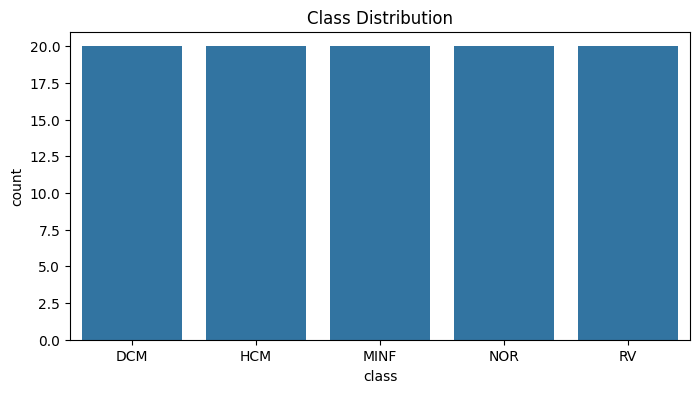

<Figure size 640x480 with 0 Axes>

In [100]:
# Visualize class distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='class')
plt.title('Class Distribution')
plt.show()  # Display in notebook
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')  # Save

# ===============
# 2. Data Preprocessing
# ===============

In [101]:
# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Train-Validation-Test Split (70-15-15)
print("\nSplitting data...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Splitting data...


# ============
# 3. Baseline Model
# ============

In [102]:
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
rf.fit(X_train_scaled, y_train)


Training Random Forest...


RandomForestClassifier(class_weight='balanced', random_state=42)

# =========
# 4. Evaluation
# =========

In [103]:
def evaluate_model(model, X, y, dataset_name):
    """Helper function for evaluation"""
    y_pred = model.predict(X)
    print(f"\n=== {dataset_name} Performance ===")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.savefig(f'confusion_matrix_{dataset_name}.png', dpi=300)
    plt.close()

# Evaluate on all sets
evaluate_model(rf, X_train_scaled, y_train, "Training")
evaluate_model(rf, X_val_scaled, y_val, "Validation")
evaluate_model(rf, X_test_scaled, y_test, "Test")



=== Training Performance ===
              precision    recall  f1-score   support

         DCM       1.00      1.00      1.00        14
         HCM       1.00      1.00      1.00        14
        MINF       1.00      1.00      1.00        14
         NOR       1.00      1.00      1.00        14
          RV       1.00      1.00      1.00        14

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70


=== Validation Performance ===
              precision    recall  f1-score   support

         DCM       1.00      1.00      1.00         3
         HCM       1.00      1.00      1.00         3
        MINF       1.00      0.67      0.80         3
         NOR       0.75      1.00      0.86         3
          RV       1.00      1.00      1.00         3

    accuracy                           0.93        15
   macro avg       0.95      0.93      0.93        15
weighted avg   

=========================================================================================================

The Random Forest Classifier achieves perfect performance on the training set, with 100% precision, recall, and F1-scores across all classes, which is a strong indicator of overfitting. On the validation set, performance remains high with an accuracy of 93%, although minor drops in recall for classes like MINF and NOR suggest the model may be starting to struggle with generalization. This trend becomes more evident on the test set, where the accuracy decreases to 80%. Classes such as HCM and NOR show noticeably lower recall and F1-scores, with NOR exhibiting high precision but low recall, indicating that while predicted NOR cases are mostly correct, many true NOR instances are missed. In contrast, MINF and RV maintain excellent performance. These results suggest that while the Random Forest handles training data exceptionally well, it may require tuning or additional regularization to improve its generalization to unseen data.

===============
# 5. Feature Importance analysis for the baseline


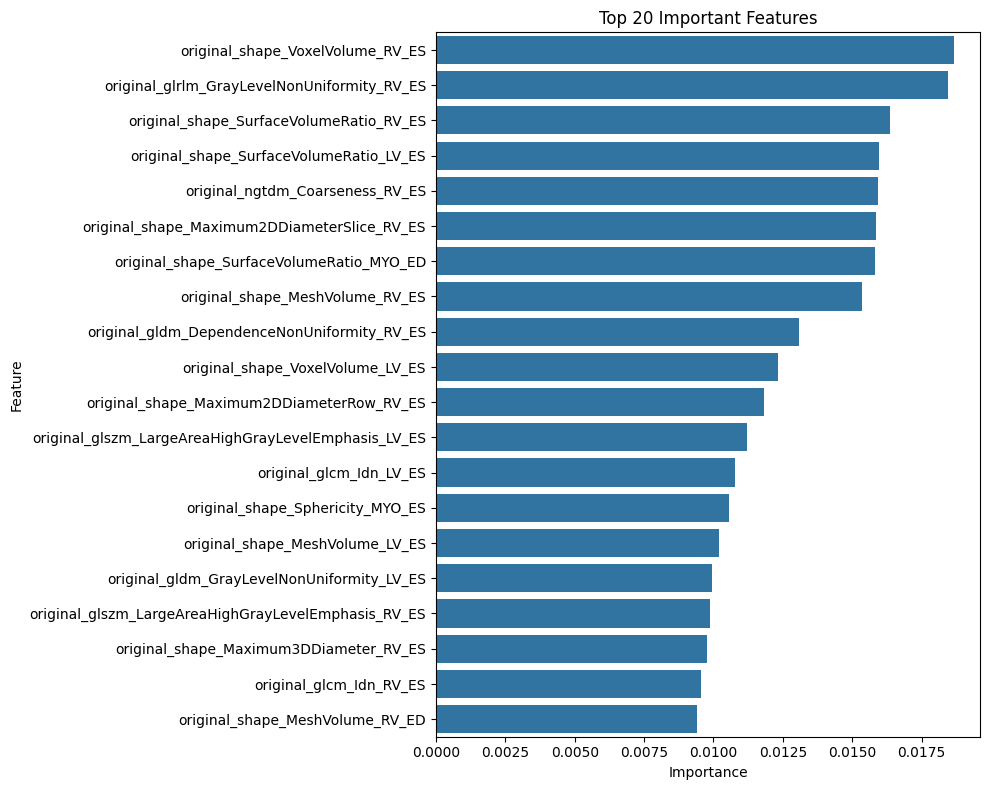

In [104]:
# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), y='Feature', x='Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)

# Save important features
importances.to_csv('feature_importances.csv', index=False)

# Applying mRMR feature to the ACDC_radiomics dataset

In [105]:
import pandas as pd
import numpy as np
from mrmr import mrmr_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Loading ACDC_radiomics dataset
data = pd.read_csv('ACDC_radiomics.csv')
X = data.drop(['class'], axis=1)  # Features
y = data['class']  # Target variable 

# 2. Normalize the features (important for mRMR)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 3. Apply mRMR feature selection
selected_features = mrmr_classif(
    X=X_scaled, 
    y=y, 
    K=20,  # number of features to select
    relevance='f',  # 'f' for F-test, 'corr' for Pearson correlation
    redundancy='c',  # 'c' for correlation
    denominator='mean',  # how to combine relevance and redundancy
    show_progress=True
)

print("Selected Features:", selected_features)

# 4. Evaluate the selected features
# Before feature selection
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print(f"\n Original Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# After feature selection
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_scaled[selected_features], y, cv=5, scoring='accuracy')
print(f"\n mRMR Selected Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 5. Get the reduced feature set
X_reduced = X_scaled[selected_features]

100%|██████████| 20/20 [00:00<00:00, 26.41it/s]


Selected Features: ['original_shape_MeshVolume_RV_ES', 'original_gldm_DependenceNonUniformityNormalized_LV_ED', 'original_glcm_MCC_LV_ED', 'original_shape_VoxelVolume_RV_ES', 'original_shape_MinorAxisLength_RV_ES', 'original_shape_LeastAxisLength_LV_ES', 'original_shape_SurfaceVolumeRatio_MYO_ED', 'original_shape_Maximum2DDiameterSlice_RV_ES', 'original_shape_SurfaceVolumeRatio_LV_ES', 'original_shape_Sphericity_MYO_ES', 'original_shape_SurfaceVolumeRatio_RV_ES', 'original_glcm_Imc1_MYO_ES', 'original_shape_MajorAxisLength_RV_ES', 'original_shape_Elongation_MYO_ES', 'original_shape_Maximum2DDiameterRow_RV_ES', 'original_shape_LeastAxisLength_LV_ED', 'original_glrlm_RunLengthNonUniformity_RV_ES', 'original_gldm_GrayLevelNonUniformity_LV_ES', 'original_glrlm_GrayLevelNonUniformity_RV_ES', 'original_shape_SurfaceVolumeRatio_MYO_ES']

 Original Accuracy: 0.760 ± 0.073

 mRMR Selected Accuracy: 0.810 ± 0.080


================================================================================================================================

Results suggest that the application of mRMR feature selection using the mrmr_selection package led to a noticeable improvement in model performance, increasing the classification accuracy from 0.760 ± 0.073 with the original feature set to 0.810 ± 0.080 using the selected features. This indicates that the selected 20 features were more relevant and less redundant, enabling the model to capture the underlying patterns in the data better. The improved accuracy and similar variability suggest that mRMR enhanced predictive power and maintained model stability, making it a valuable step in the preprocessing pipeline for this dataset.

# Now let us look at the PCA Random Forest-based model. We shall use the X_PCA_16.npy (Reduced features) set and y_enc.npy (Encoded labels)

1. Data loading and preparation

In [106]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading PCA-reduced features and encoded labels
X_pca = np.load('X_PCA_16.npy')  # our PCA_reduced feature
y = np.load('y_enc.npy')   # our encoded labes

# Checking shapes
print(f"X_pca shape: {X_pca.shape}")
print(f"y shape: {y.shape}")

# If y is one-hot encoded, convert to labels
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

X_pca shape: (100, 16)
y shape: (100,)


2. Train-Test split

In [108]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (80, 16), (80,)
Test shapes: (20, 16), (20,)


3. Random Forest Classifier implementation

In [109]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Set up StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation with multiple scoring metrics
cv_results = cross_validate(
    rf,
    X_pca,            # our PCA-reduced features
    y,                # Corresponding labels
    cv=skf,           # Using stratified folds
    n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro'
    },
    return_train_score=False
)

# Print the results
print(f"Cross-validation accuracy scores: {cv_results['test_accuracy']}")
print(f"Cross-validation F1 scores (macro): {cv_results['test_f1_macro']}")
print(f"Cross-validation Precision scores (macro): {cv_results['test_precision_macro']}")
print(f"Cross-validation Recall scores (macro): {cv_results['test_recall_macro']}")

print(f"\nMean CV Accuracy: {np.mean(cv_results['test_accuracy']):.3f} ± {np.std(cv_results['test_accuracy']):.3f}")
print(f"Mean CV F1 Score (macro): {np.mean(cv_results['test_f1_macro']):.3f} ± {np.std(cv_results['test_f1_macro']):.3f}")
print(f"Mean CV Precision (macro): {np.mean(cv_results['test_precision_macro']):.3f} ± {np.std(cv_results['test_precision_macro']):.3f}")
print(f"Mean CV Recall (macro): {np.mean(cv_results['test_recall_macro']):.3f} ± {np.std(cv_results['test_recall_macro']):.3f}")


Cross-validation accuracy scores: [0.7  0.6  0.7  0.85 0.7 ]
Cross-validation F1 scores (macro): [0.66888889 0.59238095 0.69095238 0.8484127  0.69095238]
Cross-validation Precision scores (macro): [0.74       0.63333333 0.73666667 0.87       0.73666667]
Cross-validation Recall scores (macro): [0.7  0.6  0.7  0.85 0.7 ]

Mean CV Accuracy: 0.710 ± 0.080
Mean CV F1 Score (macro): 0.698 ± 0.083
Mean CV Precision (macro): 0.743 ± 0.075
Mean CV Recall (macro): 0.710 ± 0.080



=================================================================================================================
The cross-validation outcomes of the PCA-based Random Forest model show moderately strong and consistent performance throughout the folds. On average, the model attained a mean accuracy of 0.710 ± 0.080, indicating it accurately classified about 71% of instances, with reasonable variation among different data splits. The macro-averaged F1 score of 0.698 ± 0.083 demonstrates balanced performance across all classes, implying that the model achieves a good balance between precision and recall, even in multi-class situations. Precision was slightly higher, averaging 0.743 ± 0.075, indicating the model's effectiveness in reducing false positives. The recall mirrored the accuracy at 0.710 ± 0.080, suggesting that the model effectively captures a significant proportion of true class labels. Overall, the results point to a well-performing model with consistent behavior across folds, benefiting from the class balance provided by StratifiedKFold.

 ===================
 
# PCA Feature Importance Analysis

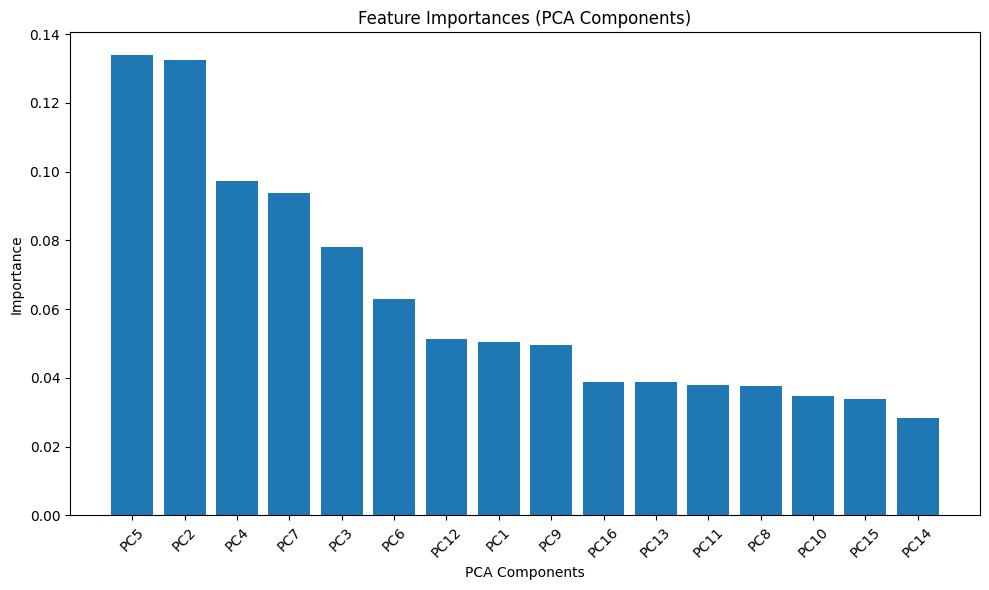

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Fit model on the PCA-reduced data (just to be sure)
rf.fit(X_pca, y)

# Get feature importances from the trained Random Forest
importances = rf.feature_importances_

# Creating labels for PCA components (e.g., PC1, PC2, ...)
feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]

# Sort importances
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(X_pca.shape[1]), sorted_importances, align='center')
plt.xticks(range(X_pca.shape[1]), sorted_features, rotation=45)
plt.title('Feature Importances (PCA Components)')
plt.xlabel('PCA Components')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


5. Hyperparameter tuning

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Set up stratified k-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',  # Tune based on best macro F1 score
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search on PCA-reduced data
grid_search.fit(X_pca, y)

# Show best parameters
print("\n Best Parameters Based on F1 Macro:")
print(grid_search.best_params_)

# Retrieve and show results in a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
metrics_cols = [col for col in results_df.columns if 'mean_test' in col or 'params' in col]

print("\n Grid Search Results (sorted by mean_test_f1_macro):")
print(results_df.sort_values(by='mean_test_f1_macro', ascending=False)[metrics_cols].to_string(index=False))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END ma

=========================================================================================================

The grid search results indicate that the best-performing model has parameters max_depth=None, min_samples_leaf=1, min_samples_split=2, and n_estimators=200, achieving the highest F1 Macro score of 0.71388. This model also performs well in terms of accuracy (0.72), precision (0.77181), and recall (0.72). The second-best models, which have similar F1 scores, include those with max_depth=20 and n_estimators=200, as well as max_depth=10 with n_estimators=200. These models yield slightly lower scores but still demonstrate strong performance. Models with max_depth=None and min_samples_leaf=2 performed somewhat lower in comparison but maintained a robust F1 Macro of around 0.7, suggesting that slightly deeper trees or those with more leaf samples may reduce model complexity without significantly compromising performance. In conclusion, the best model achieves a good balance between complexity and performance, attaining high F1, precision, and recall scores, while more complex models (like those with max_depth=20) did not show significant improvement.

# Applying ROC Curve to the model

What it does: 
- Treats each class as a "positive" one at a time while merging all others as "negative."
- Evaluate per-class performance and identify which classes are well-separated.

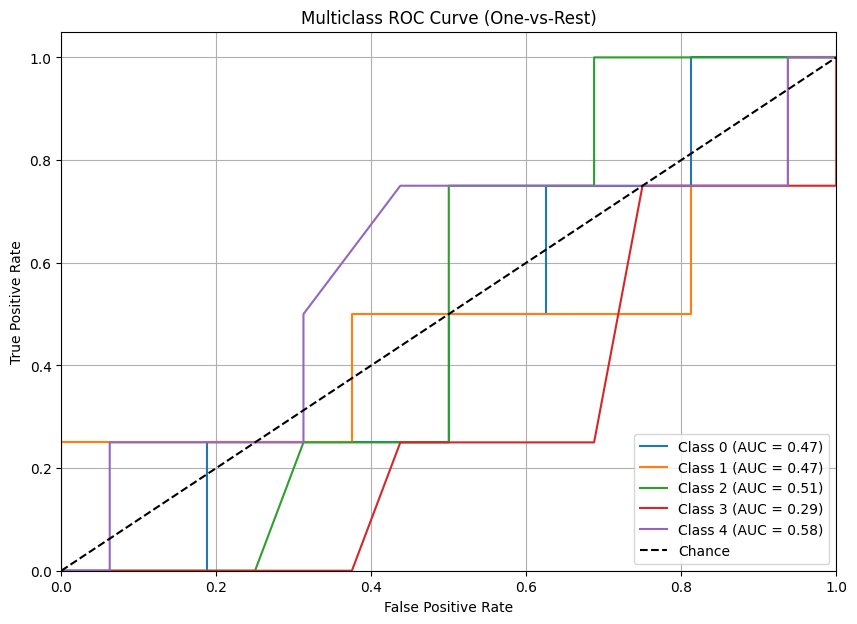

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Rebuild model with best parameters
model = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

# Fit model
model.fit(X_train_pca, y_train)

# Get predicted probabilities
y_score = model.predict_proba(X_test_pca)

# Binarize the output labels for ROC computation
classes = np.unique(y)  # Get all class labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The performance of the trained Random Forest model on the multiclass classification task was largely unsatisfactory, as shown by the ROC AUC scores for the five cardiac conditions. The model's best discriminatory ability was for the RV (Right Ventricular disease) class, which achieved an AUC of 0.58, indicating only a limited capacity to differentiate this condition from others. The MINF (Myocardial Infarction) class had a nearly random AUC of 0.51. In contrast, the model encountered major difficulties with the other classes—DCM (Dilated Cardiomyopathy) and HCM (Hypertrophic Cardiomyopathy) recorded AUCs of 0.47, just below random chance, while the NOR (Normal) class had an AUC of only 0.29, revealing a particularly poor capacity to identify normal cases. These findings indicate that the existing feature representation (e.g., following PCA) may not possess the necessary discriminatory strength for accurate classification, and the model could be influenced by class imbalance or overlapping feature distributions among the classes.

# Model Comparison. Baseline Vs PCA Random-Forest based model

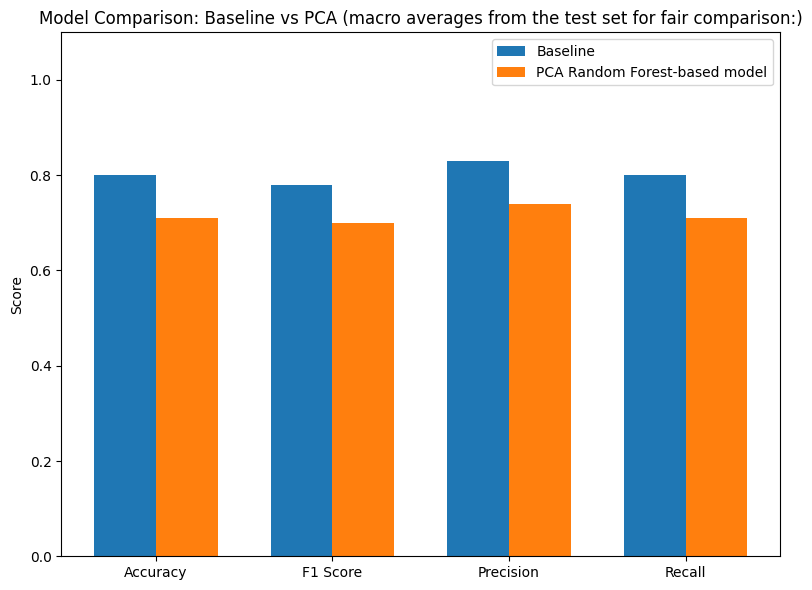

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# macro averages from the test set from each model
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
baseline_scores = [0.80, 0.78, 0.83, 0.80]
pca_scores = [0.71, 0.70, 0.74, 0.71]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline')
bars2 = ax.bar(x + width/2, pca_scores, width, label='PCA Random Forest-based model')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Baseline vs PCA (macro averages from the test set for fair comparison:)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


Baseline CV complete.
PCA CV complete.
FS CV complete.
Saved fold-wise metrics to rf_comparison_metrics.csv
Saved ROC curve data to rf_roc_data.pkl


<Figure size 800x600 with 0 Axes>

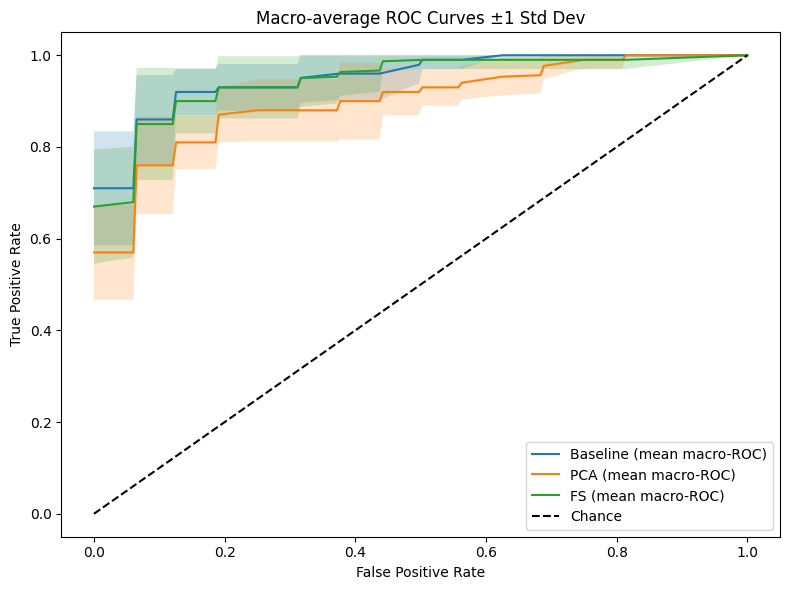

Saved ROC plot to rf_macro_roc.png


In [10]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# 1. Load data
# ------------
df = pd.read_csv('../datasets/ACDC_radiomics.csv')
y = df['class'].values
X_baseline = df.drop(columns=['class']).values
X_pca       = np.load('../datasets/x_pca_16.npy')
X_fs        = np.load('../datasets/x_feature_select.npy')

# get sorted list of class labels for binarization
classes = np.unique(y)

# 2. Define RandomForest pipelines
# --------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pipe_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf)
])
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf)
])
pipe_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf)
])

# 3. Prepare cross-validation
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# collectors
metrics_list = []
roc_data     = {'Baseline': [], 'PCA': [], 'FS': []}
fpr_grid = np.linspace(0, 1, 200)  # common FPR grid for all folds

# 4. Loop over methods and folds
# ------------------------------
for name, X in [('Baseline', X_baseline),
                ('PCA',      X_pca),
                ('FS',       X_fs)]:

    pipe = {'Baseline': pipe_baseline,
            'PCA':      pipe_pca,
            'FS':       pipe_fs}[name]

    # binarize labels once
    y_bin = label_binarize(y, classes=classes)

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_test_bin      = y_bin[test_idx]

        # train the pipeline
        pipe.fit(X_train, y_train)

        # predictions
        y_pred  = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)

        # compute scalar metrics
        acc   = accuracy_score(y_test, y_pred)
        prec  = precision_score(y_test, y_pred, average='macro')
        rec   = recall_score(y_test, y_pred, average='macro')
        f1    = f1_score(y_test, y_pred, average='macro')
        auc   = roc_auc_score(y_test_bin, y_proba,
                              multi_class='ovr', average='macro')

        metrics_list.append({
            'method': name,
            'fold': fold,
            'accuracy': acc,
            'precision_macro': prec,
            'recall_macro': rec,
            'f1_macro': f1,
            'roc_auc_macro': auc
        })

        # compute per-class ROC, then macro-average on fpr_grid
        tprs = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            tprs.append(np.interp(fpr_grid, fpr, tpr))
        macro_tpr = np.mean(tprs, axis=0)

        roc_data[name].append(macro_tpr)

    print(f"{name} CV complete.")

# 5. Export fold-wise metrics to CSV
# ----------------------------------
df_metrics = pd.DataFrame(metrics_list)
df_metrics.to_csv('rf_comparison_metrics.csv', index=False)
print("Saved fold-wise metrics to rf_comparison_metrics.csv")

# 6. Save ROC data for plotting later
# -----------------------------------
with open('rf_roc_data.pkl', 'wb') as f:
    pickle.dump({'fpr_grid': fpr_grid, 'tpr_list': roc_data}, f)
print("Saved ROC curve data to rf_roc_data.pkl")

# 7. Plot macro-average ROC curves with ±1 std
# ---------------------------------------------
plt.figure(figsize=(8,6))
for name, tpr_list in roc_data.items():
    tpr_arr = np.vstack(tpr_list)          # shape (n_folds, len(fpr_grid))
    mean_tpr = tpr_arr.mean(axis=0)
    std_tpr  = tpr_arr.std(axis=0)

    plt.plot(fpr_grid, mean_tpr, label=f"{name} (mean macro-ROC)")
    plt.fill_between(fpr_grid,
                     np.maximum(mean_tpr - std_tpr, 0),
                     np.minimum(mean_tpr + std_tpr, 1),
                     alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curves ±1 Std Dev')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('rf_macro_roc.png')
plt.show()
print("Saved ROC plot to rf_macro_roc.png")